In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import plotly.graph_objects as go
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Thu th·∫≠p v√† x·ª≠ l√≠ d·ªØ li·ªáu


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/VGC/dulieu1_3_2022-1_3_2025.csv')


In [ ]:
# B∆∞·ªõc 1: Hi·ªÉn th·ªã th√¥ng tin t·ªïng quan ƒë·ªÉ x√°c ƒë·ªãnh c·∫ßn l√†m s·∫°ch g√¨
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Ng√†y        750 non-null    object
 1   L·∫ßn cu·ªëi    750 non-null    object
 2   M·ªü          750 non-null    object
 3   Cao         750 non-null    object
 4   Th·∫•p        750 non-null    object
 5   KL          750 non-null    object
 6   % Thay ƒë·ªïi  750 non-null    object
dtypes: object(7)
memory usage: 41.1+ KB


(None,
          Ng√†y  L·∫ßn cu·ªëi        M·ªü       Cao      Th·∫•p       KL % Thay ƒë·ªïi
 0  28/02/2025  52,100.0  52,000.0  52,800.0  51,600.0  888.40K     -0.19%
 1  27/02/2025  52,200.0  52,600.0  52,600.0  51,200.0  801.30K     -0.76%
 2  26/02/2025  52,600.0  51,800.0  53,000.0  51,800.0  918.40K      1.54%
 3  25/02/2025  51,800.0  53,000.0  53,200.0  51,400.0    1.42M     -2.08%
 4  24/02/2025  52,900.0  53,100.0  53,200.0  52,400.0  605.80K      0.19%)

In [ ]:
# B∆∞·ªõc 2: ƒê·ªïi t√™n c·ªôt ngay t·ª´ ƒë·∫ßu theo chu·∫©n qu·ªëc t·∫ø
df.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', '% Daily_Change']
# B∆∞·ªõc 3: Chuy·ªÉn c·ªôt 'Date' sang ƒë·ªãnh d·∫°ng datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.sort_values('Date', inplace=True)

In [ ]:
# B∆∞·ªõc 4: H√†m x·ª≠ l√Ω gi√° tr·ªã s·ªë, b·ªè d·∫•u %, K, M, ph·∫©y,...
def convert_price(val):
    if isinstance(val, str):
        val = val.replace(',', '').replace('%', '').strip()
        if 'K' in val:
            return float(val.replace('K', '')) * 1_000
        elif 'M' in val:
            return float(val.replace('M', '')) * 1_000_000
    try:
        return float(val)
    except:
        return np.nan

In [ ]:
# B∆∞·ªõc 5: L√†m s·∫°ch c√°c c·ªôt gi√° tr·ªã s·ªë
cols_to_clean = ['Close', 'Open', 'High', 'Low', 'Volume', '% Daily_Change']
for col in cols_to_clean:
    df[col] = df[col].apply(convert_price)

In [ ]:
# B∆∞·ªõc 6: Chuy·ªÉn gi√° c·ªï phi·∫øu v·ªÅ ƒë∆°n v·ªã ngh√¨n ƒë·ªìng, l√†m tr√≤n 1 ch·ªØ s·ªë th·∫≠p ph√¢n
for col in ['Close', 'Open', 'High', 'Low']:
    df[col] = (df[col] / 1000).round(1)


In [ ]:
# B∆∞·ªõc 7: L√†m tr√≤n kh·ªëi l∆∞·ª£ng giao d·ªãch th√†nh s·ªë nguy√™n
df['Volume'] = df['Volume'].round(0).astype(int)


In [ ]:
#Ki·ªÉm tra k·∫øt qu·∫£
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 750 entries, 749 to 0
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            750 non-null    datetime64[ns]
 1   Close           750 non-null    float64       
 2   Open            750 non-null    float64       
 3   High            750 non-null    float64       
 4   Low             750 non-null    float64       
 5   Volume          750 non-null    int64         
 6   % Daily_Change  750 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 46.9 KB
None
          Date  Close  Open  High   Low   Volume  % Daily_Change
749 2022-03-01   50.5  48.9  50.5  48.3  1610000            2.67
748 2022-03-02   48.9  50.5  50.5  48.9   643000           -3.16
747 2022-03-03   49.9  48.8  49.9  48.5   811500            2.11
746 2022-03-04   50.1  50.0  50.9  49.2   910000            0.37
745 2022-03-07   51.2  49.6  51.3

## Chu·∫©n ho√° d·ªØ li·ªáu

In [ ]:
# Ch·ªâ d√πng c·ªôt close l√† bi·∫øn ƒë·∫ßu v√†o
close_prices = df[['Date', 'Close']].dropna().copy()
close_prices.set_index('Date', inplace=True)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices)

# Khai ph√° d·ªØ li·ªáu



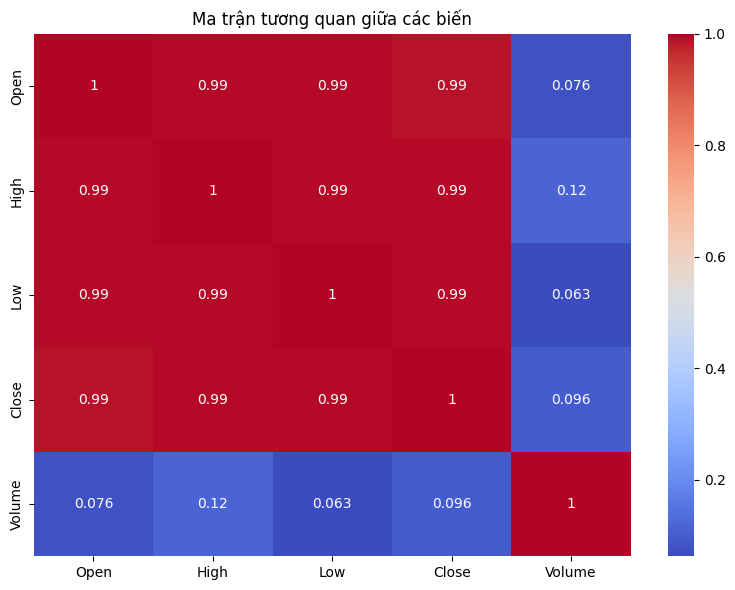

In [ ]:
# 1. Ph√¢n t√≠ch t∆∞∆°ng quan
plt.figure(figsize=(8,6))
corr = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Ma tr·∫≠n t∆∞∆°ng quan gi·ªØa c√°c bi·∫øn')
plt.tight_layout()
plt.show()

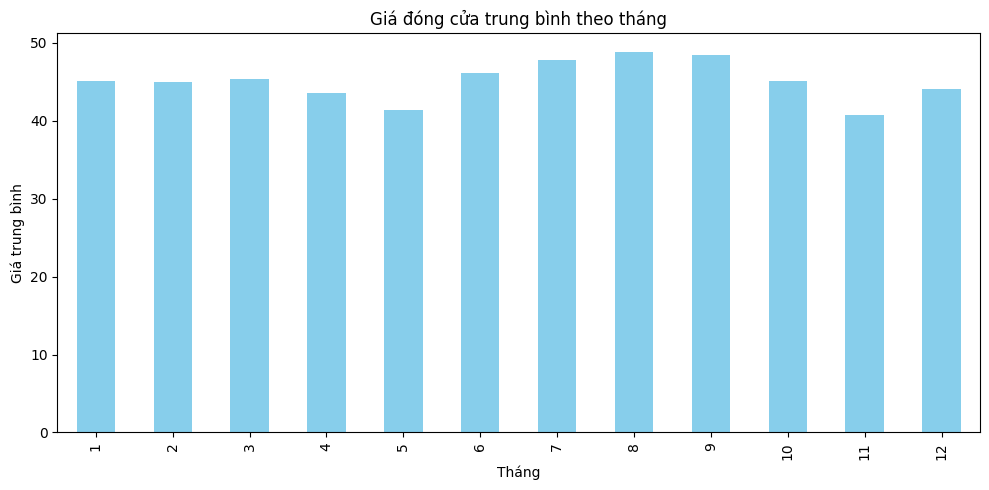

In [ ]:
# 2. Ph√¢n t√≠ch theo th·ªùi gian (th√°ng)
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

plt.figure(figsize=(10,5))
df.groupby('Month')['Close'].mean().plot(kind='bar', color='skyblue')
plt.title('Gi√° ƒë√≥ng c·ª≠a trung b√¨nh theo th√°ng')
plt.xlabel('Th√°ng')
plt.ylabel('Gi√° trung b√¨nh')
plt.tight_layout()
plt.show()

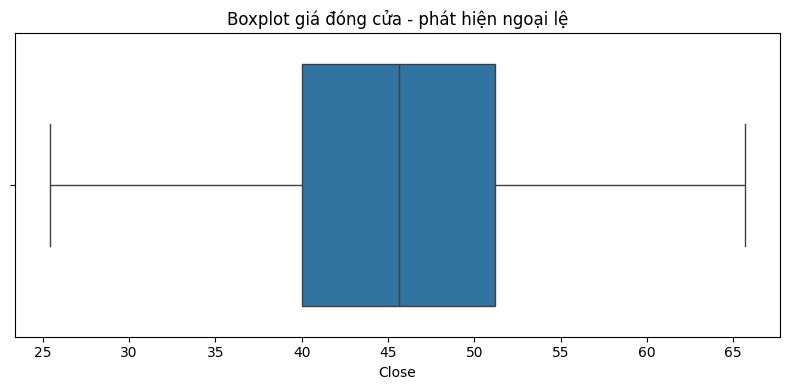

In [ ]:
# 3. Boxplot ph√°t hi·ªán ngo·∫°i l·ªá
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Close'])
plt.title('Boxplot gi√° ƒë√≥ng c·ª≠a - ph√°t hi·ªán ngo·∫°i l·ªá')
plt.tight_layout()
plt.show()


In [ ]:
# === . Ph√¢n t√≠ch th·ªëng k√™ nhanh ===
summary = {
    'Gi√° cao nh·∫•t ': df['Close'].max(),
    'Gi√° th·∫•p nh·∫•t ': df['Close'].min(),
    'Gi√° trung b√¨nh ': round(df['Close'].mean(), 2),
    'Bi·∫øn ƒë·ªông TB h√†ng ng√†y (%)': round(df['% Daily_Change'].abs().mean(), 2),
    'Kh·ªëi l∆∞·ª£ng TB': round(df['Volume'].mean()),
    'ƒê·ªô l·ªách chu·∫©n kh·ªëi l∆∞·ª£ng': round(df['Volume'].std())
}

summary_df = pd.DataFrame(list(summary.items()), columns=['Ch·ªâ s·ªë', 'Gi√° tr·ªã'])
display(summary_df)


Ch·ªâ s·ªë     Gi√° tr·ªã
0               Gi√° cao nh·∫•t        65.70
1              Gi√° th·∫•p nh·∫•t        25.40
2             Gi√° trung b√¨nh        45.14
3  Bi·∫øn ƒë·ªông TB h√†ng ng√†y (%)        2.14
4               Kh·ªëi l∆∞·ª£ng TB  1105206.00
5    ƒê·ªô l·ªách chu·∫©n kh·ªëi l∆∞·ª£ng   664609.00

In [ ]:
df.describe()

Date       Close        Open        High  \
count                            750  750.000000  750.000000  750.000000   
mean   2023-08-28 06:24:00.000000256   45.144800   45.200000   46.058267   
min              2022-03-01 00:00:00   25.400000   23.600000   25.500000   
25%              2022-11-24 06:00:00   40.025000   40.000000   40.825000   
50%              2023-08-26 12:00:00   45.650000   45.700000   46.500000   
75%              2024-05-30 18:00:00   51.200000   51.275000   51.900000   
max              2025-02-28 00:00:00   65.700000   65.700000   67.900000   
std                              NaN    8.098302    8.107219    8.208474   

              Low        Volume  % Daily_Change       Month         Year  \
count  750.000000  7.500000e+02      750.000000  750.000000   750.000000   
mean    44.325467  1.105206e+06        0.050640    6.632000  2023.146667   
min     23.600000  1.282000e+05       -7.000000    1.000000  2022.000000   
25%     39.300000  6.566750e+05       -1.425000    4.000000  2022.000000   
50%     44.800000  9.447000e+05        0.000000    7.000000  2023.000000   
75%     50.600000  1.387500e+06        1.590000   10.000000  2024.000000   
max     64.000000  5.340000e+06        7.000000   12.000000  2025.000000   
std      8.037896  6.646091e+05        2.929431    3.418405     0.891936   

           SMA_10      SMA_20      SMA_50      EMA_10      EMA_20      EMA_50  \
count  741.000000  731.000000  701.000000  750.000000  750.000000  750.000000   
mean    45.071579   45.003789   44.801749   45.135673   45.134909   45.193473   
min     28.090000   30.390000   31.344000   29.315759   30.381089   31.856716   
25%     40.550000   40.800000   41.160000   40.900706   40.962647   41.800705   
50%     45.700000   45.475000   45.110000   45.886135   46.046843   45.554216   
75%     51.180000   51.242500   51.440000   51.175702   51.390495   50.763329   
max     64.080000   62.070000   58.010000   63.349349   61.532251   56.941585   
std      7.920061    7.730677    7.163821    7.789564    7.475806    6.638924   

           RSI_14        MACD  Signal_Line  
count  737.000000  750.000000   750.000000  
mean    51.941184   -0.005408    -0.011843  
min     10.344828   -5.473328    -4.988196  
25%     38.636364   -0.623277    -0.525170  
50%     53.246753    0.132179     0.092041  
75%     65.333333    1.020181     0.956471  
max     89.763780    3.411787     3.193243  
std     17.406399    1.550099     1.449726

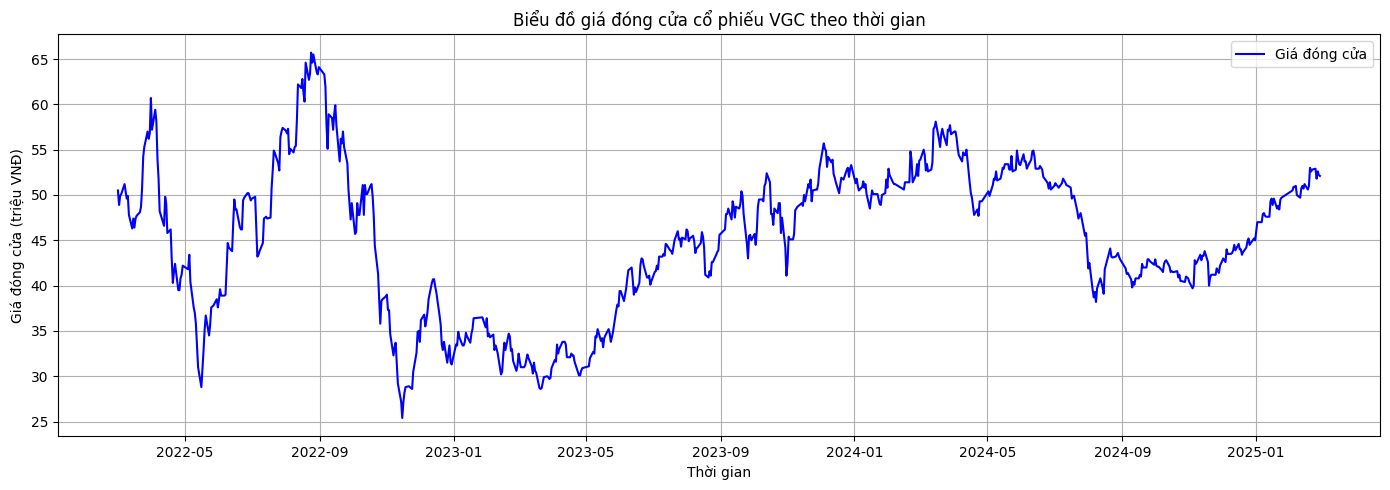

In [ ]:
# === 1. Bi·ªÉu ƒë·ªì line chart gi√° ƒë√≥ng c·ª≠a ===
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['Close'], label='Gi√° ƒë√≥ng c·ª≠a', color='blue')
plt.title('Bi·ªÉu ƒë·ªì gi√° ƒë√≥ng c·ª≠a c·ªï phi·∫øu VGC theo th·ªùi gian')
plt.xlabel('Th·ªùi gian')
plt.ylabel('Gi√° ƒë√≥ng c·ª≠a (tri·ªáu VNƒê)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# === 2. Bi·ªÉu ƒë·ªì n·∫øn (candlestick chart) ===
fig = go.Figure(data=[go.Candlestick(
    x=df['Date'],
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    increasing_line_color='green',
    decreasing_line_color='red'
)])
fig.update_layout(title='Bi·ªÉu ƒë·ªì n·∫øn c·ªï phi·∫øu VGC',
                  xaxis_title='Th·ªùi gian',
                  yaxis_title='Gi√° (tri·ªáu VNƒê)',
                  xaxis_rangeslider_visible=False,
                  template='plotly_white')
fig.show()


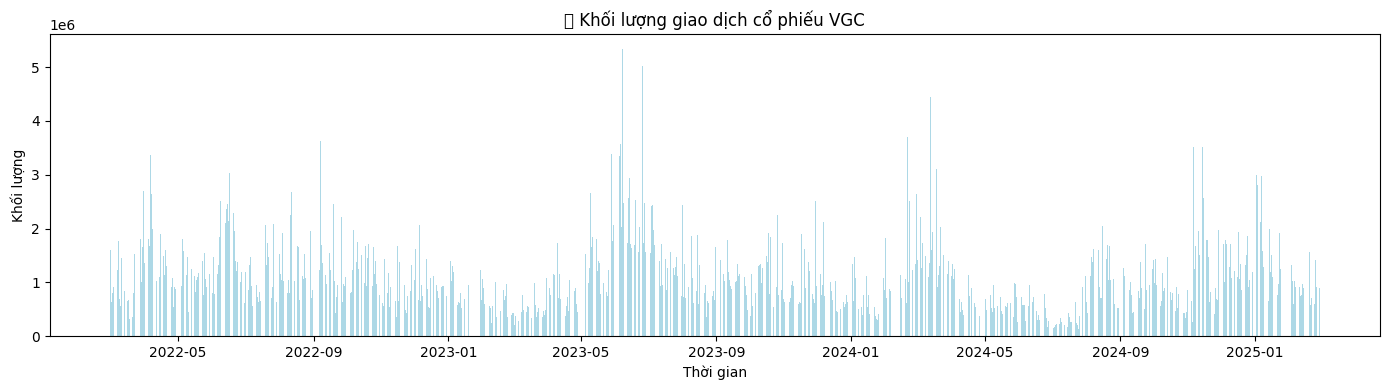

In [ ]:
# === 6. Bi·ªÉu ƒë·ªì Kh·ªëi l∆∞·ª£ng giao d·ªãch ===
plt.figure(figsize=(14, 4))
plt.bar(df['Date'], df['Volume'], color='lightblue')
plt.title("üìä Kh·ªëi l∆∞·ª£ng giao d·ªãch c·ªï phi·∫øu VGC")
plt.xlabel("Th·ªùi gian")
plt.ylabel("Kh·ªëi l∆∞·ª£ng")
plt.tight_layout()
plt.show()

In [ ]:
# Th·ªëng k√™ m√¥ t·∫£ cho c·ªôt Close
desc = df['Close'].describe()
desc

count    750.000000
mean      45.144800
std        8.098302
min       25.400000
25%       40.025000
50%       45.650000
75%       51.200000
max       65.700000
Name: Close, dtype: float64

# C√°c ch·ªâ b√°o kƒ© thu·∫≠t


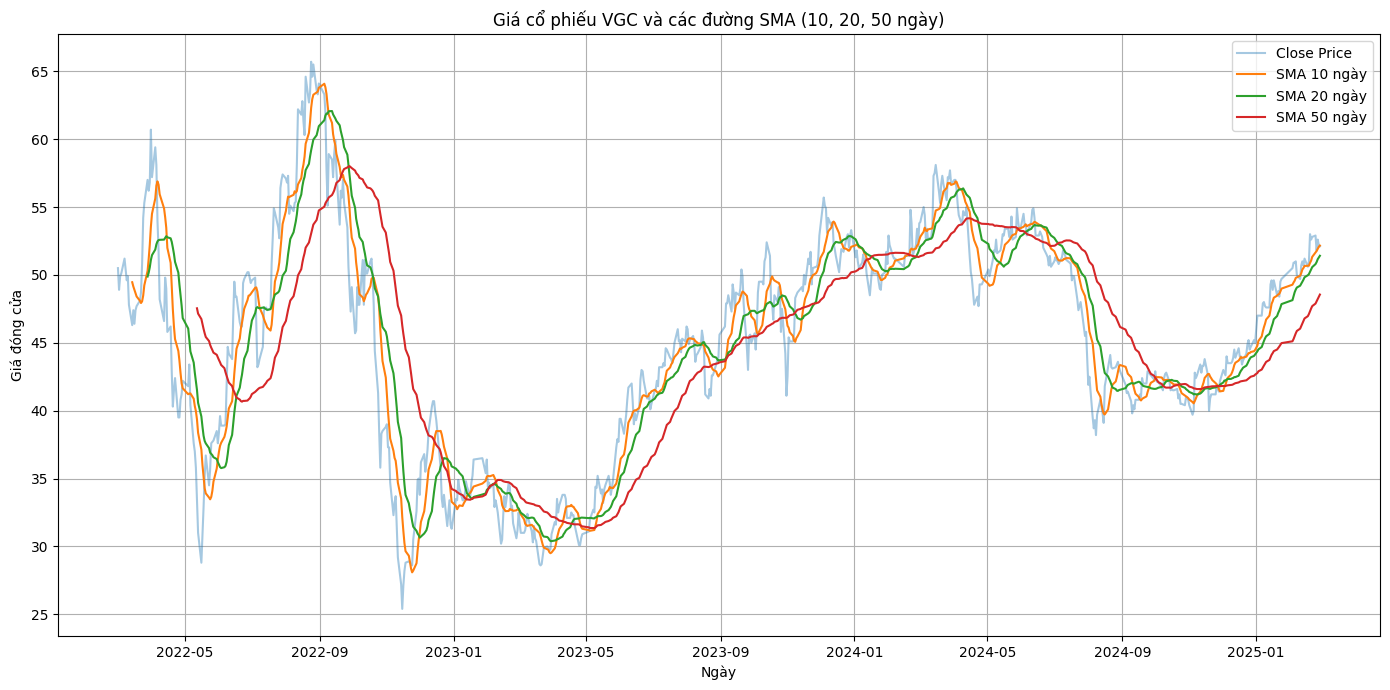

In [ ]:
#SMA # T√≠nh c√°c ƒë∆∞·ªùng SMA
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price', alpha=0.4)
plt.plot(df['Date'], df['SMA_10'], label='SMA 10 ng√†y', linewidth=1.5)
plt.plot(df['Date'], df['SMA_20'], label='SMA 20 ng√†y', linewidth=1.5)
plt.plot(df['Date'], df['SMA_50'], label='SMA 50 ng√†y', linewidth=1.5)

plt.title('Gi√° c·ªï phi·∫øu VGC v√† c√°c ƒë∆∞·ªùng SMA (10, 20, 50 ng√†y)')
plt.xlabel('Ng√†y')
plt.ylabel('Gi√° ƒë√≥ng c·ª≠a')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

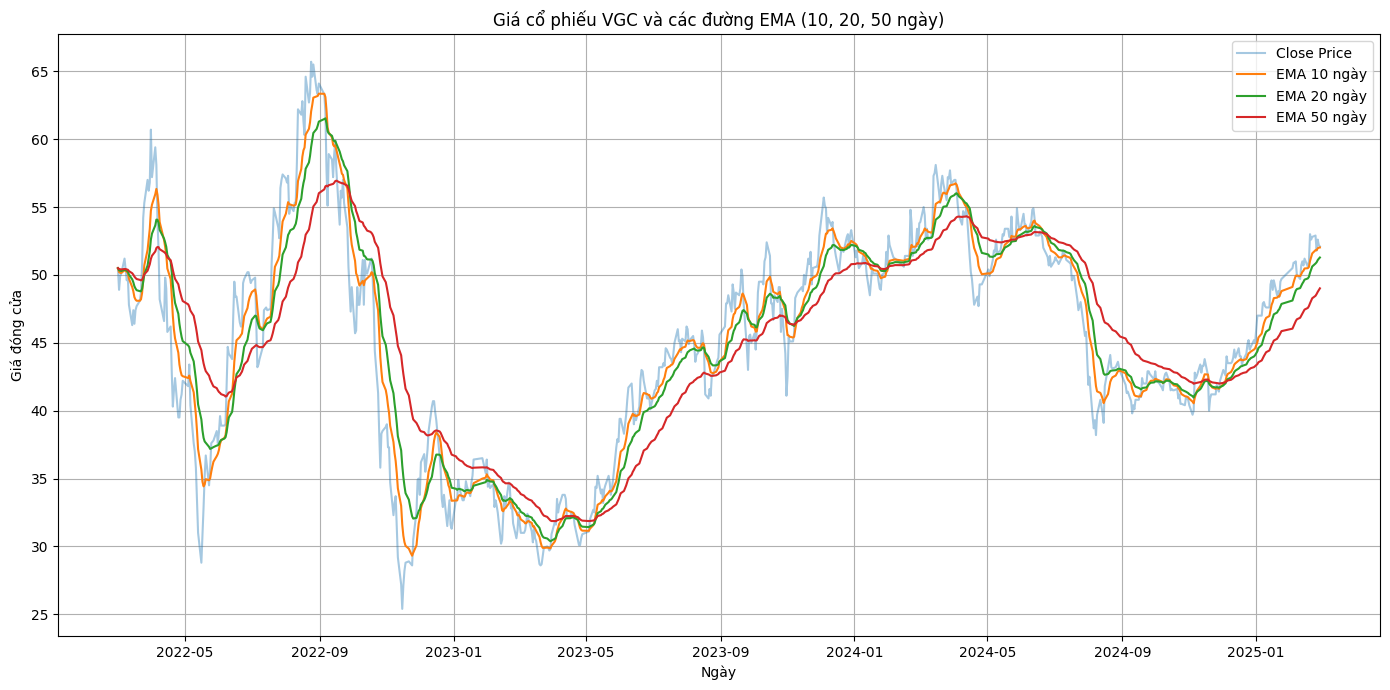

In [ ]:
# T√≠nh c√°c ƒë∆∞·ªùng EMA
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price', alpha=0.4)
plt.plot(df['Date'], df['EMA_10'], label='EMA 10 ng√†y', linewidth=1.5)
plt.plot(df['Date'], df['EMA_20'], label='EMA 20 ng√†y', linewidth=1.5)
plt.plot(df['Date'], df['EMA_50'], label='EMA 50 ng√†y', linewidth=1.5)

plt.title('Gi√° c·ªï phi·∫øu VGC v√† c√°c ƒë∆∞·ªùng EMA (10, 20, 50 ng√†y)')
plt.xlabel('Ng√†y')
plt.ylabel('Gi√° ƒë√≥ng c·ª≠a')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


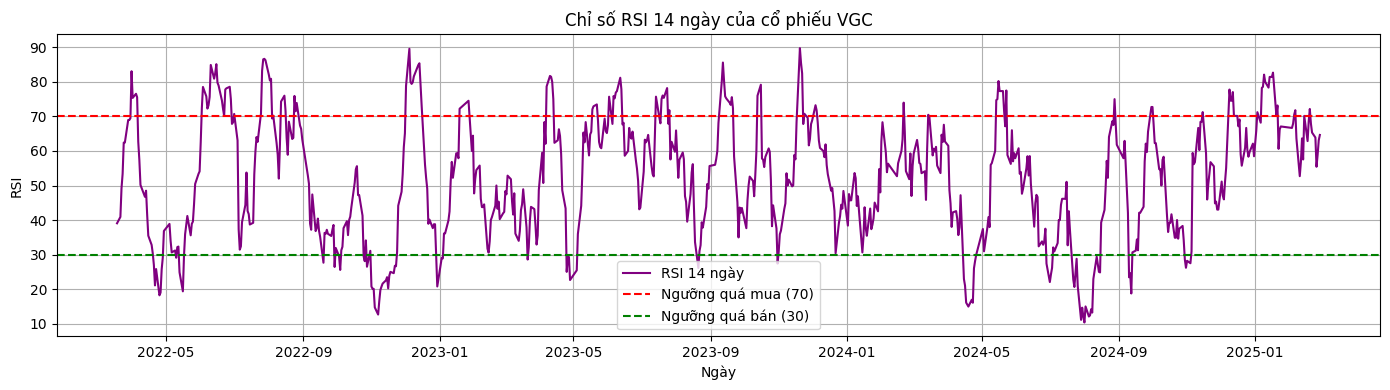

In [ ]:
# T√≠nh RSI 14 ng√†y
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# V·∫Ω bi·ªÉu ƒë·ªì RSI
plt.figure(figsize=(14, 4))
plt.plot(df['Date'], df['RSI_14'], label='RSI 14 ng√†y', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Ng∆∞·ª°ng qu√° mua (70)')
plt.axhline(30, color='green', linestyle='--', label='Ng∆∞·ª°ng qu√° b√°n (30)')
plt.title('Ch·ªâ s·ªë RSI 14 ng√†y c·ªßa c·ªï phi·∫øu VGC')
plt.xlabel('Ng√†y')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

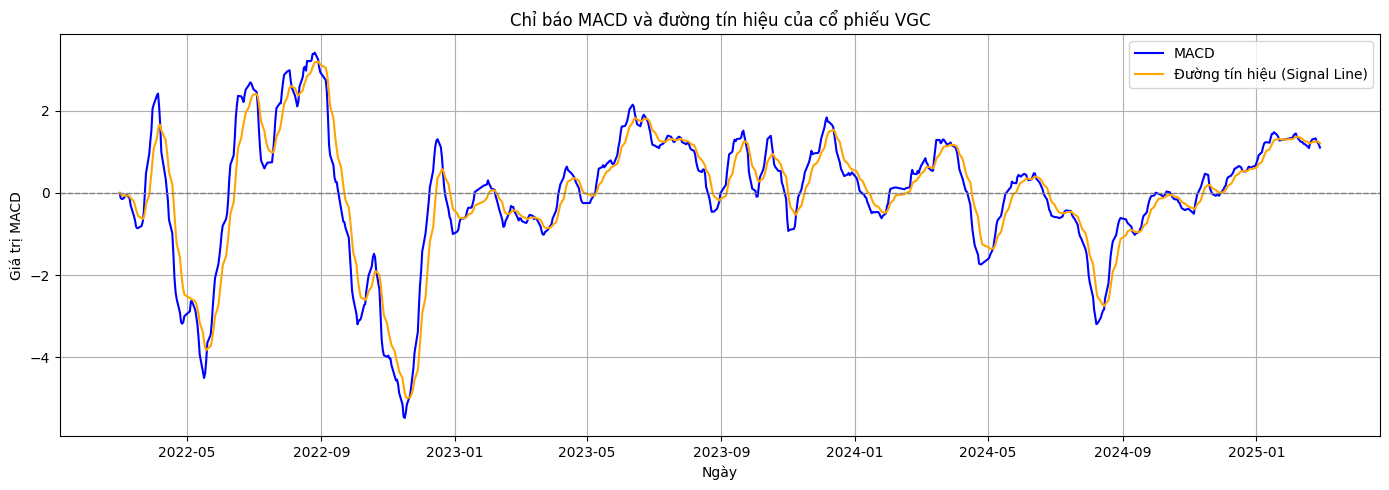

In [ ]:
# T√≠nh MACD v√† ƒê∆∞·ªùng t√≠n hi·ªáu
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# V·∫Ω bi·ªÉu ƒë·ªì MACD v√† ƒë∆∞·ªùng t√≠n hi·ªáu
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['MACD'], label='MACD', color='blue')
plt.plot(df['Date'], df['Signal_Line'], label='ƒê∆∞·ªùng t√≠n hi·ªáu (Signal Line)', color='orange')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Ch·ªâ b√°o MACD v√† ƒë∆∞·ªùng t√≠n hi·ªáu c·ªßa c·ªï phi·∫øu VGC')
plt.xlabel('Ng√†y')
plt.ylabel('Gi√° tr·ªã MACD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# X√¢y d·ª±ng m√¥ h√¨nh d·ª± b√°o

## LSTM


In [ ]:
import random
import os
import tensorflow as tf


def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
# T·∫°o t·∫≠p d·ªØ li·ªáu v·ªõi window = 30 ng√†y
def create_dataset(dataset, window_size=30):
    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i - window_size:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, 30)

In [ ]:
# Chia t·∫≠p train/test 80/20
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [ ]:
# Reshape cho LSTM (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# X√¢y d·ª±ng m√¥ h√¨nh
set_seed(42)
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)


In [ ]:
# Hu·∫•n luy·ªán m√¥ h√¨nh
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

In [ ]:
# D·ª± ƒëo√°n
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(np.concatenate([np.zeros((len(predicted_scaled), 1)), predicted_scaled], axis=1))[:, 1]
real = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), 1)), y_test.reshape(-1, 1)], axis=1))[:, 1]

5/5 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 34ms/step


In [ ]:
# T·∫°o tr·ª•c th·ªùi gian cho ph·∫ßn test
dates = close_prices.index[30+split:]

In [ ]:
# ƒê√°nh gi√° sai s·ªë
r2_lstm = r2_score(real, predicted)
mae_lstm = mean_absolute_error(real, predicted)
rmse_lstm = np.sqrt(mean_squared_error(real, predicted))
mape_lstm = mean_absolute_percentage_error(real, predicted)
print(f"üìà R¬≤ c·ªßa LSTM: {r2_lstm:.4f}")
print(f"üìâ MAE c·ªßa LSTM: {mae_lstm:.4f}")
print(f"üìâ RMSE c·ªßa LSTM: {rmse_lstm:.4f}")
print(f"üìâ MAPE c·ªßa LSTM: {mape_lstm:.4f}")

üìà R¬≤ c·ªßa LSTM: 0.9406
üìâ MAE c·ªßa LSTM: 0.7063
üìâ RMSE c·ªßa LSTM: 0.9254
üìâ MAPE c·ªßa LSTM: 0.0163


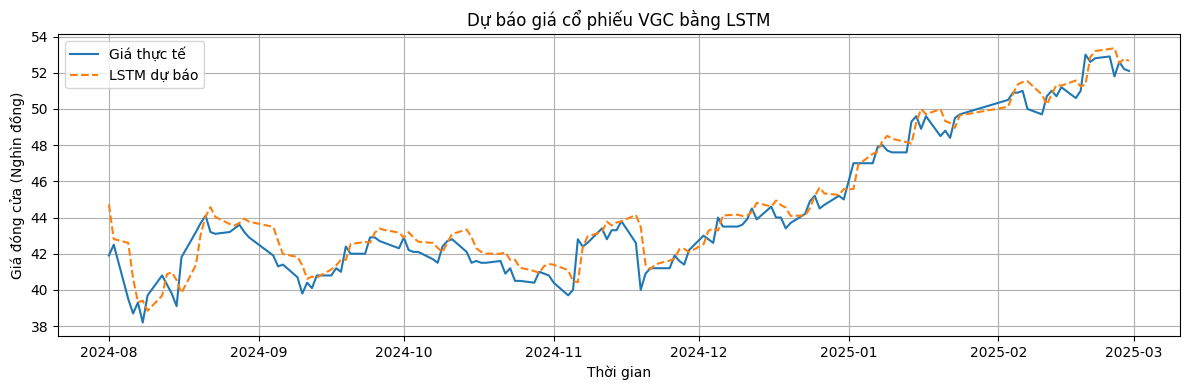

In [ ]:
# V·∫Ω bi·ªÉu ƒë·ªì so s√°nh k·∫øt qu·∫£ d·ª± b√°o v√† th·ª©c t·∫ø
plt.figure(figsize=(12, 4))
plt.plot(dates, real, label='Gi√° th·ª±c t·∫ø')
plt.plot(dates, predicted, label='LSTM d·ª± b√°o', linestyle='--')
plt.title("D·ª± b√°o gi√° c·ªï phi·∫øu VGC b·∫±ng LSTM")
plt.xlabel("Th·ªùi gian")
plt.ylabel("Gi√° ƒë√≥ng c·ª≠a (Ngh√¨n ƒë·ªìng)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

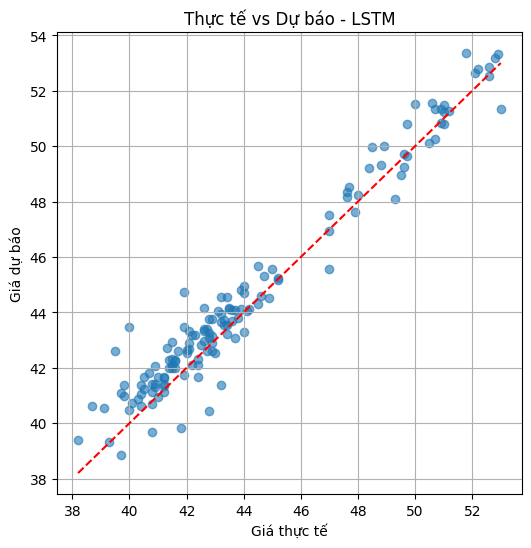

In [ ]:
# Bi·ªÉu ƒë·ªì scatter th·ª±c t·∫ø vs d·ª± b√°o
plt.figure(figsize=(6,6))
plt.scatter(real, predicted, alpha=0.6)
plt.plot([real.min(), real.max()], [real.min(), real.max()], color='red', linestyle='--')
plt.xlabel("Gi√° th·ª±c t·∫ø")
plt.ylabel("Gi√° d·ª± b√°o")
plt.title("Th·ª±c t·∫ø vs D·ª± b√°o - LSTM")
plt.grid(True)
plt.show()


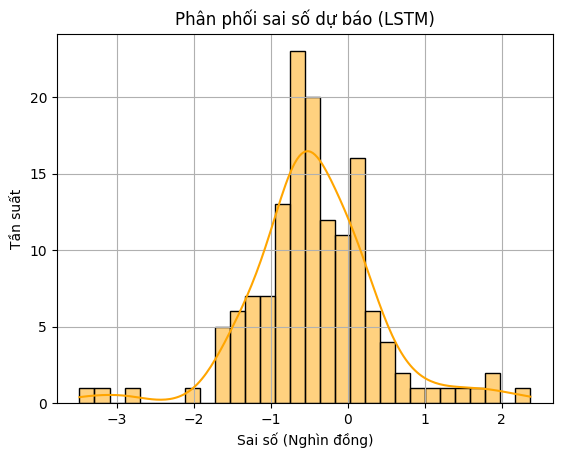

In [ ]:
#Bi·ªÉu ƒë·ªì ph√¢n ph·ªëi sai s·ªë (Histogram) c·ªßa LSTM
sns.histplot(real - predicted, bins=30, kde=True, color='orange')
plt.title("Ph√¢n ph·ªëi sai s·ªë d·ª± b√°o (LSTM)")
plt.xlabel("Sai s·ªë (Ngh√¨n ƒë·ªìng)")
plt.ylabel("T·∫ßn su·∫•t")
plt.grid(True)
plt.show()

##Random Forest Regression


In [ ]:
# S·ª≠ d·ª•ng l·∫°i scaled_data ƒë√£ ƒë∆∞·ª£c chu·∫©n h√≥a t·ª´ c·ªôt Close c·ªßa LSTM

In [ ]:
# T·∫°o t·∫≠p ƒë·∫∑c tr∆∞ng ƒë·∫ßu v√†o (sliding window) cho Random Forest, gi·ªëng v·ªõi LSTM
def create_rf_dataset(dataset, window_size=30):
    X, y = [], []# S·ª≠ d·ª•ng l·∫°i scaled_data ƒë√£ ƒë∆∞·ª£c chu·∫©n h√≥a t·ª´ c·ªôt Close

    for i in range(window_size, len(dataset)):
        X.append(dataset[i - window_size:i, 0])  # L·∫•y 30 gi√° tr·ªã li·ªÅn tr∆∞·ªõc
        y.append(dataset[i, 0])                  # Gi√° tr·ªã c·∫ßn d·ª± b√°o
    return np.array(X), np.array(y)

In [ ]:
# T·∫°o X/y cho Random Forest v·ªõi lookback = 30 (gi·ªëng LSTM)
X_rf, y_rf = create_rf_dataset(scaled_data, 30)

# Chia train/test gi·ªëng. h·ªát LSTM
split_rf = int(len(X_rf) * 0.8)
X_train_rf, y_train_rf = X_rf[:split_rf], y_rf[:split_rf]
X_test_rf, y_test_rf = X_rf[split_rf:], y_rf[split_rf:]

In [ ]:
# Hu·∫•n luy·ªán m√¥ h√¨nh Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

RandomForestRegressor(random_state=42)

In [ ]:
# D·ª± ƒëo√°n v√† inverse scale
predicted_rf_scaled = rf_model.predict(X_test_rf)
predicted_rf = scaler.inverse_transform(np.concatenate([np.zeros((len(predicted_rf_scaled), 1)), predicted_rf_scaled.reshape(-1, 1)], axis=1))[:, 1]
real_rf = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test_rf), 1)), y_test_rf.reshape(-1, 1)], axis=1))[:, 1]

In [ ]:
# T√≠nh c√°c ch·ªâ s·ªë ƒë√°nh gi√°
mae_rf = mean_absolute_error(real_rf, predicted_rf)
rmse_rf = np.sqrt(mean_squared_error(real_rf, predicted_rf))
mape_rf = mean_absolute_percentage_error(real_rf, predicted_rf)
r2_rf = r2_score(real_rf, predicted_rf)

print(f"üìà R¬≤ c·ªßa Random Forest: {r2_rf:.4f}")
print(f"üìâ MAE c·ªßa Random Forest: {mae_rf:.4f}")
print(f"üìâ RMSE c·ªßa Random Forest: {rmse_rf:.4f}")
print(f"üìâ MAPE c·ªßa Random Forest: {mape_rf:.4f}")

üìà R¬≤ c·ªßa Random Forest: 0.9374
üìâ MAE c·ªßa Random Forest: 0.7426
üìâ RMSE c·ªßa Random Forest: 0.9500
üìâ MAPE c·ªßa Random Forest: 0.0170


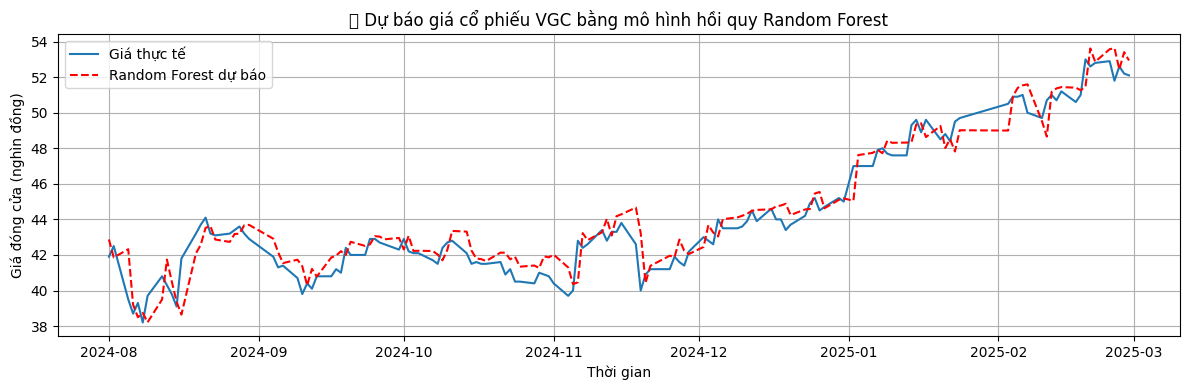

In [ ]:
# V·∫Ω bi·ªÉu ƒë·ªì so s√°nh d·ª± b√°o c·ªßa Random Forest v·ªõi gi√° th·ª±c t·∫ø
plt.figure(figsize=(12, 4))
plt.plot(dates, real, label='Gi√° th·ª±c t·∫ø')
plt.plot(dates, predicted_rf, label='Random Forest d·ª± b√°o', linestyle='--', color='red')
plt.title("üìà D·ª± b√°o gi√° c·ªï phi·∫øu VGC b·∫±ng m√¥ h√¨nh h·ªìi quy Random Forest")
plt.xlabel("Th·ªùi gian")
plt.ylabel("Gi√° ƒë√≥ng c·ª≠a (ngh√¨n ƒë·ªìng)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

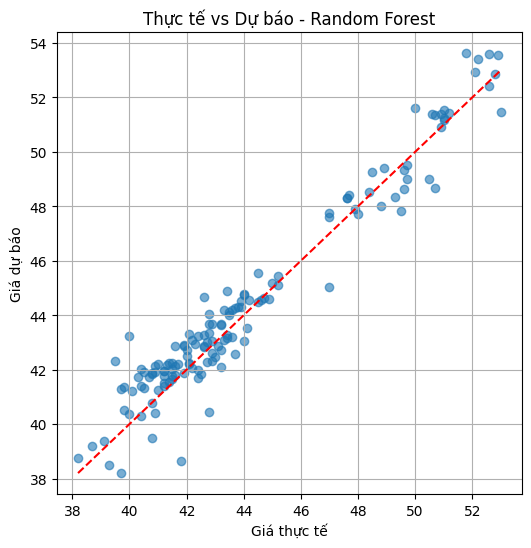

In [ ]:
# Bi·ªÉu ƒë·ªì scatter th·ª±c t·∫ø vs d·ª± b√°o
plt.figure(figsize=(6,6))
plt.scatter(real, predicted_rf, alpha=0.6)
plt.plot([real.min(), real.max()], [real.min(), real.max()], color='red', linestyle='--')
plt.xlabel("Gi√° th·ª±c t·∫ø")
plt.ylabel("Gi√° d·ª± b√°o")
plt.title("Th·ª±c t·∫ø vs D·ª± b√°o - Random Forest")
plt.grid(True)
plt.show()

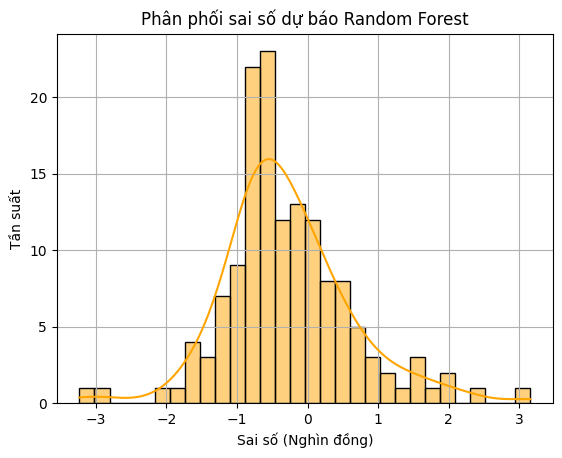

In [ ]:
#Bi·ªÉu ƒë·ªì ph√¢n ph·ªëi sai s·ªë (Histogram) c·ªßa LSTM
sns.histplot(real - predicted_rf, bins=30, kde=True, color='orange')
plt.title("Ph√¢n ph·ªëi sai s·ªë d·ª± b√°o Random Forest")
plt.xlabel("Sai s·ªë (Ngh√¨n ƒë·ªìng)")
plt.ylabel("T·∫ßn su·∫•t")
plt.grid(True)
plt.show()